In [1]:
#from lmfit import minimize, Parameters # Not implemented here yet (but in prototype 01 Chemostat it is)

In [1]:
# 

#import pandas
import numpy as np
#import scipy.interpolate as intrp

import sys
sys.path.append('../../phydra_OSM/')

from phydra.aux import sliceparams, sliceoffparams, checkreplaceparam
from phydra.forcing import Forcing

from lmfit import minimize, Parameters #, Parameter, report_fit

In [2]:
from scipy.io import netcdf

In [3]:
import matplotlib

In [4]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [5]:
@xs.process
class ExternalForcing:
    """Process supplies forcing"""
    #  -20, 47, 2.
    lat = xs.variable(default=47)
    lon = xs.variable(default=-20)
    rbb = xs.variable(default=2.)
    
    forcing = xs.variable(intent='out')
    
    def initialize(self):
        self.forcing = Forcing('WOA2018', self.lat, self.lon, self.rbb)

In [6]:
@xs.process
class UniqueComponent:
    """This is for initializing a Nutrient (i.e. components that are unique (0D))"""
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    
    def initialize(self):
        self.label = (self.component_label,) # labels are collected as tuples in initialization
        self.init = np.array(self.initVal)   # properties are collected as numpy arrays (might be better ways to do this)

In [7]:
@xs.process
class Nutrient(UniqueComponent):
    """There is only one Nutrient component in the current model setup, that is consumed by all Phytoplankton and get's replenished with a certain supply rate"""
    component_label = xs.variable(default='N', groups='component-label')
    
    initVal = xs.variable(default=1, description='initial Nutrient concentration')
    
    supplyrate = xs.variable(default=1, description='Nutrient supply rate', groups='parameter', static=True)

    # Process variables
    supply = xs.variable(intent='out')
    
    def _supply(self):
        return self.supplyrate
    
    def initialize(self):
        super(Nutrient, self).initialize() # for label & init
        self.supply = self._supply

In [8]:
@xs.process
class Detritus(UniqueComponent):
    """There is only one Detritus component in the current model setup, phytoplankton mortality and zooplankton excretion ends up in this pool that sinks and gets remineralized"""
    component_label = xs.variable(default='D', groups='component-label')
    
    initVal = xs.variable(default=1, description='initial Detritus concentration')
    
    remin_rate = xs.variable(default=.1, description='Detritus remineralization rate', groups='parameter', static=True)

    # Process variables
    remineralize = xs.variable(intent='out')
    
    def _remineralize(self, D):
        return self.remin_rate * D
    
    def initialize(self):
        super(Detritus, self).initialize() # for label & init
        self.remineralize = self._remineralize

In [9]:
@xs.process
class FlexSizeComponent:
    """This is for initializing both Phytoplankton and Zooplankton (i.e. components of variable number (1D))"""
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    size = xs.variable(dims='flexComponent',intent='out', groups='size')
        
    def calculate_sizes(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize_alloparams(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        # Note: i need some way to distinguish every individual component, even within FlexSizeComponents, so I am doing this:
        self.label = tuple((self.component_label + str(i) for i in range(self.NP))) 
        
        self.init = np.array([self.initVal / self.NP for i in range(self.NP)])
        
        self.size = self.calculate_sizes()

        self.initialize_alloparams()

In [153]:
@xs.process
class Phytoplankton(FlexSizeComponent):
    """The current model setup contains 40 Phytoplankton, ordered by Size (ESD = equivalent spherical diameter)"""
    component_label = xs.variable(default='P', groups='component-label')
    # Phytoplankton params
    PMinEsd = xs.variable(default = 1,  description='P size range minimum ESD', groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P size range maximum ESD', groups='parameter', static=True)
    NP =      xs.variable(default = 40, description='number of P - and Z',  groups='parameter', static=True)
    
    # INPUT
    initVal = xs.variable(description='initial total Phytoplankton concentration')
    m = xs.variable(default=.1, description='Phytoplankton mortality', groups='parameter', static=True)
    
    # Allometric params
    ks = xs.variable(intent='out', description='allometric half-saturation constant',  groups='alloparameter')
    mu0 = xs.variable(intent='out', description='allometric growth rate',  groups='alloparameter')
    
    # Process variables
    uptake = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    grazed = xs.variable(intent='out')
    
    def _uptake(self, N):
        return self.mu0 * N / (N + self.ks)
    
    def _mortality(self):
        """returns size-scaled mortality rate, calculated from mu0"""
        return self.m * self.mu0 
    
    def _grazed(self,FgrazP):
        """returns grazed biomass (by all Z) per P"""
        return [sum(FgrazP[i,:]) for i in range(self.NP)]
    
    def calculate_sizes(self):
        """initializes array of sizes from ESD size range and number of P"""
        numbers = np.array([i for i in range(self.NP)])
        sizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / (self.NP-1) + np.log(self.PMinEsd)
        print(sizes)
        return np.exp(sizes)
    
    def initialize_alloparams(self):
        """initializes allometric parameters based on array of sizes (ESD)
        allometric relationships are taken from meta-analyses of lab data"""
        self.mu0 = 2.6 * (self.size) ** -0.45
        self.ks = (self.size) * .1
        
    def initialize(self):
        """Phytoplankton initialization calls FlexSizeComponent initialize()
        and assigns process functions to be used in ODE"""
        super(Phytoplankton, self).initialize()
        self.uptake = self._uptake
        self.mortality = self._mortality
        self.grazed = self._grazed

In [154]:
@xs.process
class Zooplankton(FlexSizeComponent):
    """The current model setup contains 40 Zooplankton, ordered by Size (ESD = equivalent spherical diameter)"""
    component_label = xs.variable(default='Z', groups='component-label')
    # SetupParams
    PMinEsd = xs.foreign(Phytoplankton, 'PMinEsd')
    PMaxEsd = xs.foreign(Phytoplankton, 'PMaxEsd')
    NP =      xs.foreign(Phytoplankton, 'NP')
    phytosize = xs.foreign(Phytoplankton, 'size')
   
    # Zooplankton params 
    initVal =    xs.variable(description='initial total Zooplankton concentration')
    zeta =       xs.variable(default=1,  description='Z quadratic mortality', groups='parameter', static=True)
    deltaxprey = xs.variable(default=0.25,  description='log10 prey size tolerance', groups='parameter', static=True)
    KsZ =        xs.variable(default=3,  description='grazing half saturation constant', groups='parameter', static=True)
    f_eg =       xs.variable(default=.33,  description='egested grazed biomass', groups='parameter', static=True)
    epsilon =    xs.variable(default=.33,  description='assimilated grazed biomass', groups='parameter', static=True)
    
    
    # Allometric params
    I0 = xs.variable(intent='out', description='Z allometric uptake rate',  groups='alloparameter')
    xpreyopt = xs.variable(intent='out', description='Z allometric optimal prey size',  groups='alloparameter')
    
    phiP = xs.variable(intent='out', description='grazing preference matrix')
    
    # Process variables
    grazingmatrix = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    ingestion = xs.variable(intent='out')
    excretion = xs.variable(intent='out')
    
    def _grazingmatrix(self,P,Z):
        """calculates biomass grazed as a matrix of P and Z"""
        PscaledAsFood = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):
                PscaledAsFood[i,j] = self.phiP[i,j] / self.KsZ * P[i]
        
        FgrazP = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):        
                FgrazP[i,j] = self.I0[j] * Z[j] * PscaledAsFood[i,j] / (1 + sum(PscaledAsFood[:,j]))
                
        return FgrazP
    
    def _ingestion(self,FgrazP):
        """calculates biomass assimilated of P per Z"""
        return [self.epsilon * sum(FgrazP[:,j]) for j in range(self.NP)]

    def _excretion(self,FgrazP):
        """calculates biomass excreted back into N pool of P per Z"""
        return [(1 - self.f_eg - self.epsilon) * sum(FgrazP[:,j]) for j in range(self.NP)]
    
    def _mortality(self,Z):
        """returns quadratic mortality (multiplied by sum of all Z)"""
        return self.zeta * sum(Z)
        
    def calculate_sizes(self):
        """initializes array of sizes from ESD size range of Z based on size range of P
        so that each P has an optimized grazer"""
        zoosizes= 2.16 * self.phytosize ** 1.79
        return zoosizes
    
    def initialize_alloparams(self):
        """initializes allometric parameters based on array of sizes (ESD)"""
        self.I0 = 26 * (self.size) ** -0.4
        self.xpreyopt = 0.65 * (self.size) ** .56 # which should equal = self.phytosize
    
    def init_phiP(self):
        """creates array of feeding preferences [P...P10] for each [Z] based on ESD and deltaxprey"""
        phiP= np.array([[np.exp(-((np.log10(xpreyi)-np.log10(xpreyoptj)) / self.deltaxprey)**2) 
               for xpreyi in self.phytosize] for xpreyoptj in self.xpreyopt])
        return phiP
    
    def initialize(self):         
        """Zooplankton initialization calls FlexSizeComponent initialize()
        and assigns process functions to be used in ODE"""       
        super(Zooplankton, self).initialize()
        self.grazingmatrix = self._grazingmatrix
        
        self.mortality = self._mortality
        self.ingestion = self._ingestion
        self.excretion = self._excretion
        
        self.phiP = self.init_phiP()

In [155]:
import itertools

def flatten(generatorlist):
    # returns 1D list from nested generator or multi-D list
    return list(itertools.chain.from_iterable(generatorlist))

In [156]:
@xs.process
class Chemostat:
    # foreign processes
    physx = xs.foreign(ExternalForcing, 'forcing') # new FORCING!
    
    N_supply = xs.foreign(Nutrient, 'supply')
    
    P_uptake = xs.foreign(Phytoplankton, 'uptake')
    P_mortality = xs.foreign(Phytoplankton, 'mortality')
    
    grazingmatrix = xs.foreign(Zooplankton, 'grazingmatrix')
    Z_ingestion = xs.foreign(Zooplankton, 'ingestion')
    Z_excretion = xs.foreign(Zooplankton, 'excretion')
    Z_mortality = xs.foreign(Zooplankton, 'mortality')
    P_grazed = xs.foreign(Phytoplankton, 'grazed')
    
    D_remin = xs.foreign(Detritus, 'remineralize')
    
    # model construct labels
    complabels = xs.group('component-label')
    labels = xs.group('label')
    inits = xs.group('init')
    
    # output variables
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        """model state is initialized"""
        self.time = 0

        # This is one of those things I am not sure about, it makes sense to use dicts to store model state (to allow calling different components by labels)
            # BUT this can not be used (afaik) in a nice way as output for plotting later on in the model output xarray.. do you have any idea how to do that more nicely?
        self.state = {label:val for label,val in zip(self.complabels,self.inits)}

        # in order to have output to plot, I also create an array that contains all output:
            # i have to use flatten function (defined above) to make group generators one dimensional (FlexComponents are Lists, so generators return List of Lists)
            # there should be a better solution to this.. but it relates to how xs.group() works in this model setup (i wrote more on this in "open questions" below)
        self.stateout = np.concatenate([self.state[label] for label in flatten(self.complabels)], axis=None)
        
        self.component = [i for i in flatten(self.labels)]
    
    def ode(self, state, time, labels, timestep):
        #slab addons:
        MLD = self.physx.MLD.return_interpvalattime(time)
        MLDderiv = self.physx.MLD.return_derivattime(time)
        N0 = self.physx.NOX.return_interpvalattime(time)
        PAR = self.physx.PAR.return_interpvalattime(time)
        Tmld = self.physx.SST.return_interpvalattime(time)
        
        MIX = (0.1 + max(MLDderiv,0)) / MLD
        
        """the ode function defines the fluxes, based on functions passed from components
        state is split into the component parts and merged again, after calculating fluxes"""
        N, P, Z, D = state['N'], state['P'], state['Z'], state['D']
        
        # this was in Neil Bana's original code, however does not seem necessary here:
        #P[P < 0.01] = 0.01
        #Z[Z < 0.01] = 0.01
        
        PGrazed = self.grazingmatrix(P,Z)
        #print('Nsupply',self.N_supply() * MIX)
        #print('Nsupply2',(N0-N) * MIX)
        #print('Dremin',self.D_remin(D) )
        dNdt = (N0-N) * MIX - sum(self.P_uptake(N)*P) + sum(self.Z_excretion(PGrazed)) + self.D_remin(D)
        
        dPdt = self.P_uptake(N)*P - self.P_mortality()*P - self.P_grazed(PGrazed) - P * MIX
        
        dZdt =  self.Z_ingestion(PGrazed) - self.Z_mortality(Z)*Z  - Z * MIX
        
        dDdt = sum(self.P_mortality()*P) - D * MIX * 15 # sinkrate v is 3, 0.33 digestion rate Z
        
        # need to convert fluxes to correct time step (rates per day) by multiplying by dt        
        return {'N':dNdt*timestep, 'P':dPdt*timestep, 'Z':dZdt*timestep, 'D':dDdt*timestep}

    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        """fluxes are calculated per timestep"""
        self.outflux = self.ode(self.state,self.time,self.labels, dt)
        
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        """new model state is calculated from fluxes"""
        self.state = {label : self.state[label] + self.outflux[label] for label in self.complabels}
        
        # state for computation, stateout for plotting later (this seems stupid)
        self.stateout = np.concatenate(flatten([(self.state[label] for label in self.complabels)]), axis=None)

In [157]:
ASTroCATclone = xs.Model({'physx':ExternalForcing, 'env':Chemostat, 'N':Nutrient, 'P':Phytoplankton, 'Z':Zooplankton, 'D':Detritus})

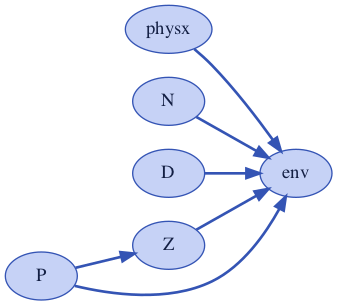

In [158]:
ASTroCATclone.visualize()

In [159]:
model_in = xs.create_setup(
        model=ASTroCATclone,
    clocks={
         'time': np.linspace(1,10,100)  # 10*365,10*365*9)
     },
    input_vars={
        'N__initVal':1,    # inital Nutrient amount
        'N__supplyrate':5, # nutrient supply rate
        
        'P__initVal': 1,   # inital total biomass of Phytoplankton
        'P__PMinEsd': .5,   # minimal Phytoplankton Size Spectral range
        'P__PMaxEsd': 50,  # minimal Phytoplankton Size Spectral range
        'P__NP': 3,       # number of Phytoplankton Types (=num of Zooplankton Types)
        'P__m': .1,        # mortality rate of Phytoplankton
        
        'Z__initVal': 1,   # inital total biomass of Zooplankton
        'Z__zeta': .1,      # mortality rate quadratic
        'Z__deltaxprey': .25,  # log10 prey size tolerance
        'Z__KsZ': 3,       # grazing half saturation constant
        'Z__f_eg': .33,    # egested food
        'Z__epsilon': .33,  # assimilated food
        
        'D__initVal': 0.1  # initial Detritus Biomass
    },
    output_vars={
        'env__component': None,
        'P__size': None,
        'Z__size': None,
        'env__stateout': 'time'
    }
)

In [160]:
model_out = model_in.xsimlab.run(model=ASTroCATclone)

mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created
[-0.69314718  1.60943791  3.91202301]


In [161]:
model_out

<xarray.Dataset>
Dimensions:             (component: 8, flexComponent: 3, time: 100)
Coordinates:
  * time                (time) float64 1.0 1.091 1.182 ... 9.818 9.909 10.0
Dimensions without coordinates: component, flexComponent
Data variables:
    P__component_label  <U1 'P'
    Z__KsZ              int64 3
    D__initVal          float64 0.1
    P__m                float64 0.1
    Z__component_label  <U1 'Z'
    physx__lon          int64 -20
    P__PMinEsd          float64 0.5
    N__component_label  <U1 'N'
    N__supplyrate       int64 5
    P__PMaxEsd          int64 50
    Z__epsilon          float64 0.33
    D__component_label  <U1 'D'
    Z__f_eg             float64 0.33
    D__remin_rate       float64 0.1
    P__NP               int64 3
    Z__deltaxprey       float64 0.25
    Z__zeta             float64 0.1
    physx__rbb          float64 2.0
    physx__lat          int64 47
    N__initVal          int64 1
    P__initVal          int64 1
    Z__initVal          int64 1
    env__stateout       (time, component) float64 1.0 0.1 ... 0.3296 0.1564
    env__component      (component) <U2 'N' 'D' 'P0' 'P1' 'P2' 'Z0' 'Z1' 'Z2'
    P__size             (flexComponent) float64 0.5 5.0 50.0
    Z__size             (flexComponent) float64 0.6246 38.51 2.375e+03

## you can save model output here

In [144]:
# uncomment line to save model output:
#model_out.to_netcdf('phydra_prototype_ASTroCAT_10y_x90day_timestep.nc')

In [145]:
#  three PFTs based on size – picophytoplankton (0.5–2 µm in diameter), nanophytoplankton (2–20 µm) and microphytoplankton (20–50 µm).

In [146]:
data_coordfix = model_out.set_index(component = 'env__component', P__sizes='P__size', Z__sizes='Z__size')

In [147]:
P_out = data_coordfix.sel(component=['P'+str(i) for i in range(3)])
Z_out = data_coordfix.sel(component=['Z'+str(i) for i in range(3)])
N_out = data_coordfix.sel(component='N')
D_out = data_coordfix.sel(component='D')

In [148]:
resolution = 10
resmpl_step = 1

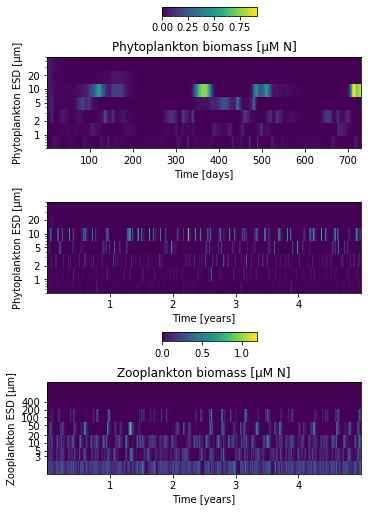

In [151]:
plt.rcParams['figure.figsize'] = [5, 7]

#f1, (ax1col, ax1, ax2, ax2col, ax3) = plt.subplots(5, 3, gridspec_kw={'height_ratios': [.1,1,1,.1,1]})#, sharey='row')

fig = plt.figure(constrained_layout=True)

gs = fig.add_gridspec(nrows=5, ncols=3,
                        hspace=0.1, wspace=0.1, height_ratios=[.1,1,1,.1,1])

ax1col = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 0:3])
ax2 = fig.add_subplot(gs[2, 0:3])
ax3col = fig.add_subplot(gs[3, 1])
ax3 = fig.add_subplot(gs[4, 0:3])


#plt.setp(ax1, xticks=[1,180,365,365+180,720])
#from matplotlib.ticker import MaxNLocator
#for axe in [ax1]:
#        axe.grid(True, alpha=0.5)
#        axe.get_yaxis().set_major_locator(MaxNLocator(nbins=4))
#        axe.tick_params(top=False, right=True, direction="in")

#plt.setp((ax2, ax3), xticks=[1,365,2*365,3*365,4*365,5*365,6*365,7*365,8*365,9*365,10*365])
#from matplotlib.ticker import MaxNLocator
#for axe in (ax2, ax3):  
#        axe.grid(True, alpha=0.5)
#        axe.get_yaxis().set_major_locator(MaxNLocator(nbins=4))
#        axe.tick_params(top=False, right=True, direction="in")
        
ax1.set_title('Phytoplankton biomass [µM N]')
ax1plt = ax1.pcolormesh(P_out.time[:365*2*resolution:resmpl_step],P_out.P__sizes,
               P_out.env__stateout[:365*2*resolution:resmpl_step].T)
ax1plt
ax1.set_yscale('log')
ax1.set_yticks([1,2,5,10,20])
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.colorbar(ax1plt,cax=ax1col, orientation='horizontal')
ax1.set_ylabel('Phytoplankton ESD [µm]')
ax1.set_xlabel('Time [days]')
    
ax2.pcolormesh(P_out.time[::resolution],P_out.P__sizes,P_out.env__stateout[::resolution].T)
ax2.set_yscale('log')
ax2.set_yticks([1,2,5,10,20])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel('Phytoplankton ESD [µm]')
ax2.set_xlabel('Time [years]')
ax2.set_xticklabels(labels=[i for i in range(0,10)])

ax3.set_title('Zooplankton biomass [µM N]')
ax3plt = ax3.pcolormesh(Z_out.time[::resolution],Z_out.Z__sizes,Z_out.env__stateout[::resolution].T)
ax3plt
ax3.set_yscale('log')
ax3.set_yticks([3,5,10,20,50,100,200,400])
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.colorbar(ax3plt, cax=ax3col, orientation='horizontal')
ax3.set_ylabel('Zooplankton ESD [µm]')
ax3.set_xlabel('Time [years]')
ax3.set_xticklabels(labels=[i for i in range(0,10)])

# Defining custom 'xlim' and 'ylim' values.
#xlim = (0, 365*9+364)

# Setting the values for all axes.
#plt.setp((ax2, ax3), xlim=xlim)

#f1.align_ylabels()


#plt.savefig('ASTroCAT_out.jpg', bbox_inches='tight')
plt.show()

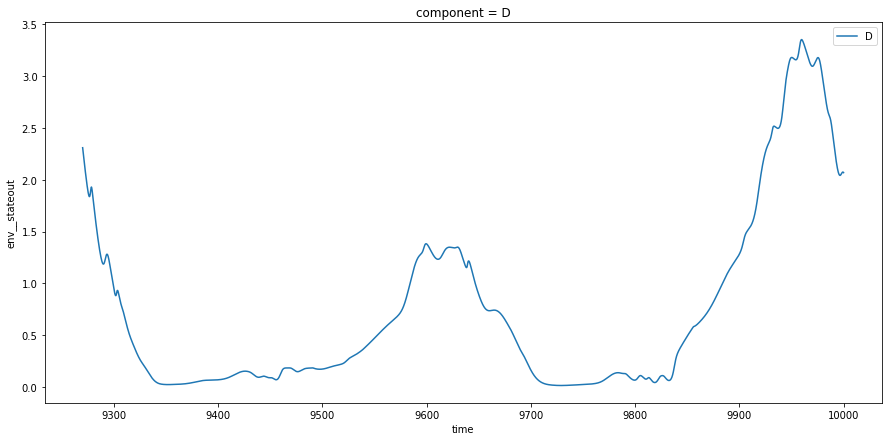

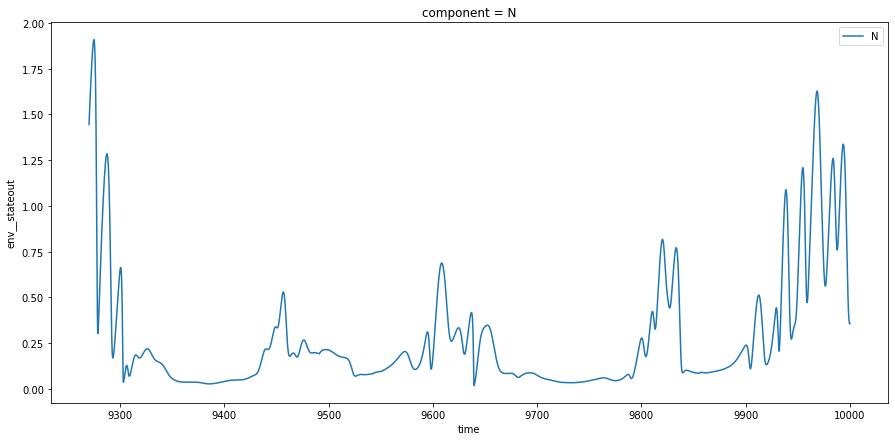

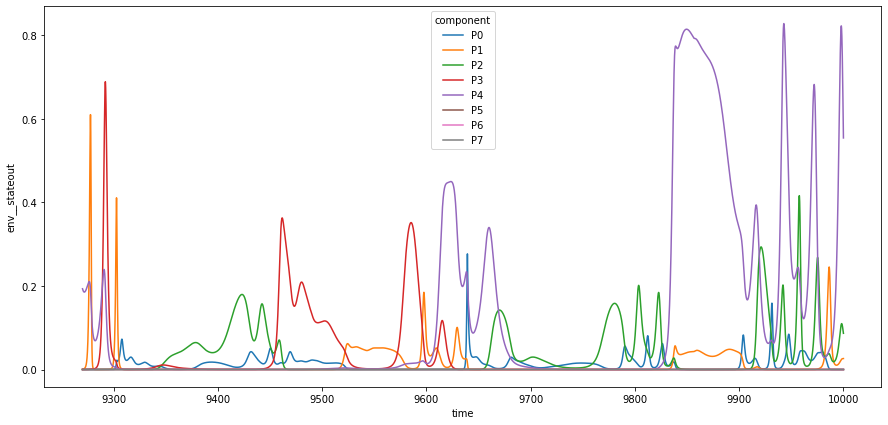

In [152]:
plt.rcParams['figure.figsize'] = [15, 7]

D_out.env__stateout[-365*2*resolution:].plot.line(x='time', label='D')
plt.legend()
plt.show()

N_out.env__stateout[-365*2*resolution:].plot.line(x='time', label='N')
plt.legend()
plt.show()

P_out.env__stateout[-365*2*resolution:].plot.line(x='time', label='P')


plt.rcParams['figure.figsize'] = [5, 7]

In [124]:
forx2 = Forcing('WOA2018', 0, -20, 2)

mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created


In [125]:
forx = Forcing('WOA2018', 47, -20, 2)

mld forcing created
n0x forcing created
sst forcing created
par forcing created
VerifData forcing created


In [126]:
forx.verif.carbontotal

[20.521269,
 24.576805,
 31.30174,
 41.34429,
 55.28756,
 58.36141,
 40.183094,
 24.89001,
 25.273169,
 30.776497,
 34.788586,
 29.957521]

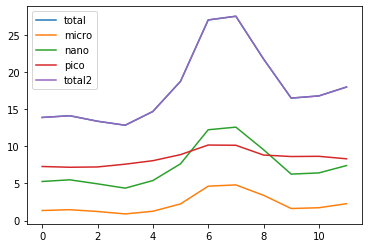

In [25]:
#forx.verif.c_microp, forx.verif.c_picop, forx.verif.c_nanop
forx = forx2
plt.plot(forx.verif.carbontotal, label='total')
plt.plot(forx.verif.c_microp, label='micro')
plt.plot(forx.verif.c_nanop, label='nano')
plt.plot(forx.verif.c_picop, label='pico')

#plt.plot(np.array(forx.verif.c_nanop)+np.array(forx.verif.c_microp)+np.array(forx.verif.c_picop), label='total2')
plt.legend()

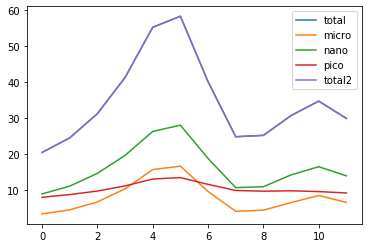

In [24]:
#forx.verif.c_microp, forx.verif.c_picop, forx.verif.c_nanop
plt.plot(forx.verif.carbontotal, label='total')
plt.plot(forx.verif.c_microp, label='micro')
plt.plot(forx.verif.c_nanop, label='nano')
plt.plot(forx.verif.c_picop, label='pico')

plt.plot(forx.verif., label='pico')

#plt.plot(np.array(forx.verif.c_nanop)+np.array(forx.verif.c_microp)+np.array(forx.verif.c_picop), label='total2')
plt.legend()

In [23]:
np.array(forx.verif.c_nanop)+np.array(forx.verif.c_microp)+np.array(forx.verif.c_picop)

array([20.521278, 24.576801, 31.301716, 41.34429 , 55.28755 , 58.36147 ,
       40.183094, 24.890053, 25.273163, 30.776514, 34.788567, 29.957548],
      dtype=float32)

## plot of output 
was created in "02_ASTroCAT_PLOT_OUTPUT.ipynb" notebook


![](ASTroCAT_out.jpg)

# Open issues:

## 1. there must be a better way to keep track of the model state, right?
better than storing in a dict (with labels) and as a flattened list (for later plotting) at the same time.
The "problem" is my use of FlexComponents, which puts variables that contain lists in groups, therefore the generators return lists of lists in the Chemostat process, that do not correspond to the dimensionality needed in xarray (afaik). Perhaps the implementation of dimensions (i.e. coordinates and indices) could use an overhaul in this model.

in prototype 01_Chemostat it is implemented differently, instead of FlexComponents that contain arrays, I have multiple instances of each "UniqueComponent". Would that be the better way to go perhaps? Perhaps i could have a parent process that creates all instances of the single components (like the allometric parametrisation done here).. but I am not sure what the technical implementation would look like, particularly regarding xs.Model() construction. (I don't want to spell out 80 components there.)

and more broadly:
## 2. what is the best way to structure the xarray to contain all aspects of the model?
it should store all relevant inputs, outputs and parameters for later analysis in an easily accesible manner.

## 3. what is the best way to implement switching to odeint (unfixed steps)
The prototype 01_Chemostat model allows for using odeint, I have not implemented it in this example yet, but it should be realitvely straighforward to pass the _ode_ function to it. I am not sure how to keep track of the output then though.

## 4. how could this structure allow for an easy implementation of dimensionality?
e.g. so that there are multiple "chemostats" components interacting in a grid.

### 5. (not sure if feasible) but would be amazing, if the visualization of the model represented ecological components with their links & processes
by this I mean that the visualisation shows the components of the model as boxes (Nutrient, Phytoplankton, Zooplankton), and the defined processes on arrows between boxes (Nutrient --N_Uptake--> Phytoplankton).
If there was some modification to the model construction or the visualisation function that would allow this, it would be quite neat!